In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python import keras as kt
# RNN imports
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, RNN, SimpleRNN, GRU
from keras.utils import to_categorical


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


Using TensorFlow backend.


In [2]:
# Separate data by subject

# samples from subject 0
idx_p0_train = np.where(person_train_valid == 0)[0]
idx_p0_test = np.where(person_test == 0)[0]

p0_train_X = X_train_valid[idx_p0_train] 
p0_train_y = y_train_valid[idx_p0_train]

p0_test_X = X_test[idx_p0_test]
p0_test_y = y_test[idx_p0_test]

print(p0_train_X.shape)
print(p0_train_y.shape)
print(p0_test_X.shape)
print(p0_test_y.shape)



(237, 25, 1000)
(237,)
(50, 25, 1000)
(50,)


In [3]:
################################
# Sliding window subsampling

# data size (1000, 25)
# sample size (100, 25)
# for loop over each trial
# for loop over each valid index
# append the cut out section to the new dataset
# append the cut out section's label tothe new dataset labels

test_array_x = np.array([[[1,2,3,4,5,6,7,8,9,10]],
                       [[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]],
                       [[1,2,3,4,5,6,7,8,9,10]]])


test_array_y = np.array([700,701,702])

def crop_data_aug(X, y, crop):
    crop_size = crop # 3 # 100
    original_train_X = X  # test_array_x # p0_train_X
    original_train_y = y # test_array_y # p0_train_y

    N, C, T = original_train_X.shape
    print("Original Data:", original_train_X.shape, original_train_y.shape)
    #print("X", original_train_X[300:305], "Y", original_train_y[300:305])
    cropped_train_X = np.zeros((N*(T-crop_size+1), C, crop_size))
    cropped_train_y = np.zeros(N*(T-crop_size+1))
    crops_per_sample = T-crop_size+1


    for n in np.arange(N):
        crop_count = 0
        for t in np.arange(T-crop_size+1):
            idx = n*crops_per_sample + crop_count
            cropped_train_X[idx] = original_train_X[n, :, t:t+crop_size]
            cropped_train_y[idx] = original_train_y[n]
            crop_count = crop_count + 1
            
    print("Cropped Data:", cropped_train_X.shape, cropped_train_y.shape)
    
    return cropped_train_X, cropped_train_y

# separate the train and val test sets before actually cropping 
idx_val = np.arange(p0_train_X.shape[0])
np.random.shuffle(idx_val)
val_fraction = int(0.2*idx_val.shape[0])

# separated train and test splits
data_val_X = p0_train_X[0:val_fraction]
data_val_y = p0_train_y[0:val_fraction]
data_train_X = p0_train_X[val_fraction:]
data_train_y = p0_train_y[val_fraction:]

# augment using cropping
cropped_train_X, cropped_train_y = crop_data_aug(data_train_X, data_train_y, 300)
cropped_val_X, cropped_val_y = crop_data_aug(data_val_X, data_val_y, 300)


Original Data: (190, 25, 1000) (190,)
Cropped Data: (133190, 25, 300) (133190,)
Original Data: (47, 25, 1000) (47,)
Cropped Data: (32947, 25, 300) (32947,)


In [4]:
################################
# rearrange data for Keras modules

##!!!!!! Now train and test data dimensions do not match

# fomat data to (batch_size, timesteps, input_dim)
k_X_train = np.swapaxes(cropped_train_X, 1, 2)
k_X_val = np.swapaxes(cropped_val_X, 1, 2)
k_X_test = np.swapaxes(p0_test_X, 1, 2)
print("Swapped axes:",k_X_train.shape, k_X_test.shape)
# remove VOG channels (23-25)
k_X_train = k_X_train[: , : , :22 ]
k_X_val = k_X_val[:, :, :22]
k_X_test = k_X_test[: , : , :22 ]
print("Removed VOG channels:", k_X_train.shape, k_X_test.shape)

# encode output labels
print("Raw labels:", cropped_train_y[0:10])
k_y_train = cropped_train_y - 769
k_y_val = cropped_val_y - 769
k_y_test = p0_test_y - 769
print("Fixed:", k_y_train[0:10])
k_y_train_categ = to_categorical(k_y_train, 4)
k_y_val_categ = to_categorical(k_y_val, 4)
k_y_test_categ = to_categorical(k_y_test, 4)
print("Categorical one-hot encoding:\n",k_y_train_categ[0:3])

Swapped axes: (133190, 300, 25) (50, 1000, 25)
Removed VOG channels: (133190, 300, 22) (50, 1000, 22)
Raw labels: [771. 771. 771. 771. 771. 771. 771. 771. 771. 771.]
Fixed: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Categorical one-hot encoding:
 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [5]:
#################### RNN paramters
hids = 100
actv = 'tanh'
dcy = 0.005
reg = 0.1
lrt = 0.00005

#1 Plain

#################### RNN training
from keras.layers import Dropout
input_dim = k_X_train.shape[1:]
gru_units_sub = 128

model = Sequential()
model.add(keras.layers.Conv1D(22, 10, input_shape=input_dim))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(22, 10))
model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.CuDNNLSTM(64, input_shape=input_dim, return_sequences=True))
#model.add(Dropout(0.5))
model.add(keras.layers.CuDNNGRU(gru_units_sub, input_shape=input_dim))
model.add(keras.layers.BatchNormalization())
model.add(Dense(4, activation="softmax"))
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

print(model.summary())

history = model.fit(k_X_train, k_y_train_categ, 
                    validation_data=(k_X_val, k_y_val_categ),
                    epochs=5, verbose=1, batch_size=256)



#################### RNN loss and accuracy plotting
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 291, 22)           4862      
_________________________________________________________________
batch_normalization_1 (Batch (None, 291, 22)           88        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 282, 22)           4862      
_________________________________________________________________
batch_normalization_2 (Batch (None, 282, 22)           88        
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 128)               58368     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total para

KeyboardInterrupt: 

In [46]:
model.save("Conv-BN-Conv-BN-GRU1-128units-BN-subsampling300-valacc54.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 291, 20)           4420      
_________________________________________________________________
batch_normalization_45 (Batc (None, 291, 20)           80        
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 282, 20)           4020      
_________________________________________________________________
batch_normalization_46 (Batc (None, 282, 20)           80        
_________________________________________________________________
cu_dnngru_12 (CuDNNGRU)      (None, 128)               57600     
_________________________________________________________________
batch_normalization_47 (Batc (None, 128)               512       
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 516       
Total para

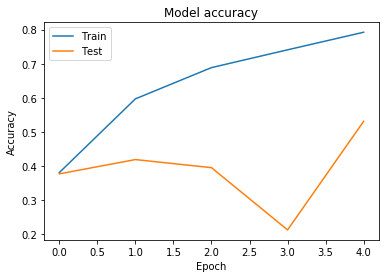

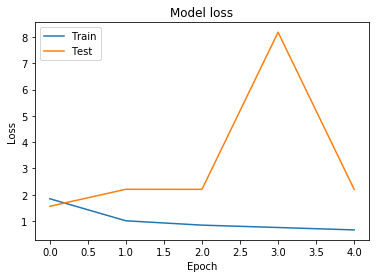

In [49]:

#2 Regularization

#################### RNN training
input_dim = k_X_train.shape[1:]
gru_units_sub = 128

model = Sequential()

model.add(keras.layers.Conv1D(20, 10, input_shape=input_dim, 
                             kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(20, 10, kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.CuDNNGRU(gru_units_sub, input_shape=input_dim,
                recurrent_regularizer=keras.regularizers.l2(0.01), 
                kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.BatchNormalization())
model.add(Dense(4, activation="softmax"))
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

print(model.summary())

history = model.fit(k_X_train, k_y_train_categ, 
                    validation_data=(k_X_val, k_y_val_categ),
                    epochs=5, verbose=1, batch_size=256)



#################### RNN loss and accuracy plotting
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [50]:
model.save("Conv-BN-Conv-BN-GRU1-128units-reg-subsampling300-valacc53.h5")


#3 Dense to output


#4 Increase crop length

#5 LSTM